# Notebook 3: Implementación de Estrategia Momentum

## Objetivo
Implementación de selección mensual de activos usando metodología MSCI Momentum adaptada. 
**OPTIMIZADO:** Usa retornos pre-calculados del Notebook 2 (R_12, R_6), evitando loops de ventanas.

## Metodología MSCI Momentum

Para cada fecha de rebalanceo:
1. **Filtrar elegibles:** Usar `eligibility_mask` para obtener activos elegibles
2. **Obtener retornos pre-calculados:** R_12 y R_6 del Notebook 2
3. **Calcular Z-scores:** Normalización dentro del universo elegible
4. **Score compuesto:** Media de Z_12 y Z_6
5. **Seleccionar top 30:** Activos con mayor score (top 20 principales + 10 reservas)
6. **Sistema de reservas:** Los primeros 20 se guardan como selección principal (`ticker_1` a `ticker_20`), y los siguientes 10 como reservas (`reserva_1` a `reserva_10`) para reemplazar automáticamente activos que sufran delistings entre la fecha de selección y la fecha de ejecución en el Notebook 4

## Índice
1. [Configuración e Imports](#configuracion)
2. [Carga de Datos](#carga)
3. [Funciones de Cálculo Vectorizadas](#funciones)
4. [Loop Principal de Selección](#loop)
5. [Visualizaciones y Validaciones](#visualizaciones)
6. [Guardado de Resultados](#guardado)

---

## 1. Configuración e Imports {#configuracion}

Esta sección configura el entorno de trabajo, importa las librerías necesarias y define los parámetros críticos de la estrategia de selección.

**Decisiones clave:**
- **N_ACTIVOS_SELECCION = 20**: La estrategia selecciona exactamente 20 activos equiponderadamente por fecha de rebalanceo. Sin embargo, se calculan los top 30 activos usando `select_top_n(scores, n=30)`, guardando los primeros 20 como selección principal y los siguientes 10 como reservas para manejar delistings.
- **Sistema de reservas**: Se guardan 30 activos en total (top 20 + 10 reservas) para manejar casos donde algunos tickers seleccionados queden sin precio disponible en la fecha de ejecución debido a delistings que ocurren entre la fecha de selección (t-1) y la fecha de ejecución (t). Las reservas permiten reemplazo automático en el Notebook 4, manteniendo siempre 20 activos válidos en la cartera. 
- **Uso de datos procesados del Notebook 2**: Se cargan retornos pre-calculados (R_12, R_6) y máscara de elegibilidad del Notebook 2, evitando recalcular ventanas móviles en cada iteración. Esta optimización reduce tiempo de ejecución crítico para análisis de sensibilidad y validación cruzada.
- **Formato de salida estructurado**: El CSV generado sigue formato estándar (fecha + 20 columnas de tickers) compatible con el motor de backtesting del Notebook 4, facilitando la integración entre notebooks y garantizando consistencia en el pipeline.

In [1]:
"""
Notebook 3: Implementación de Estrategia Momentum

Genera señales de selección mensual usando:
- Retornos pre-calculados (R_12, R_6) del Notebook 2
- Z-scores normalizados por universo elegible
- Selección de top 20 activos por score compuesto

OUTPUT: CSV con 20 tickers seleccionados por fecha de rebalanceo
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración
DATA_PROCESSED_DIR = '../datos/processed'
N_ACTIVOS_SELECCION = 20

# Estilo de visualizaciones
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

print("="*70)
print("NOTEBOOK 3: IMPLEMENTACIÓN DE ESTRATEGIA MOMENTUM")
print("="*70)

NOTEBOOK 3: IMPLEMENTACIÓN DE ESTRATEGIA MOMENTUM


## 2. Carga de Datos {#carga}

Esta sección carga los datos procesados del Notebook 2: retornos acumulados pre-calculados (R_12, R_6) y la máscara de elegibilidad que define el universo de inversión en cada fecha.

**Decisiones clave:**
- **Retornos pre-calculados (R_12, R_6)**: En lugar de calcular ventanas móviles en cada iteración, se usan retornos acumulados pre-calculados del Notebook 2. Esto elimina loops costosos y aprovecha operaciones vectorizadas de pandas, reduciendo tiempo de ejecución en órdenes de magnitud y permitiendo análisis iterativos rápidos.
- **Formato WIDE (fechas × tickers)**: Los DataFrames en formato WIDE permiten acceso directo por fecha usando `.loc[fecha]`, facilitando operaciones eficientes de filtrado y selección. Este formato es consistente con el Notebook 2 y optimizado para el tipo de acceso secuencial por fecha que requiere el loop de selección.
- **Verificación de integridad**: Se valida que los shapes de retornos y elegibilidad coincidan, garantizando consistencia de datos y detectando errores de procesamiento temprano. Esta validación es crítica para evitar errores en tiempo de ejecución durante el loop principal.

In [2]:
print("\n" + "="*70)
print("CARGANDO DATOS PROCESADOS")
print("="*70)

# Cargar retornos pre-calculados
returns_12m_rebal = pd.read_parquet(f'{DATA_PROCESSED_DIR}/returns_12m_rebal.parquet')
returns_6m_rebal = pd.read_parquet(f'{DATA_PROCESSED_DIR}/returns_6m_rebal.parquet')
eligibility_mask = pd.read_parquet(f'{DATA_PROCESSED_DIR}/eligibility_mask.parquet')
rebalance_dates = pd.read_csv(f'{DATA_PROCESSED_DIR}/rebalance_dates.csv', 
                               parse_dates=['date'])['date']

print(f"Retornos 12M: {returns_12m_rebal.shape}")
print(f"Retornos 6M: {returns_6m_rebal.shape}")
print(f"Eligibility mask: {eligibility_mask.shape}")
print(f"Fechas de rebalanceo: {len(rebalance_dates)}")

# Verificación de formato WIDE
assert returns_12m_rebal.shape == eligibility_mask.shape, "Shapes inconsistentes"
print("\n✓ Datos cargados correctamente")


CARGANDO DATOS PROCESADOS
Retornos 12M: (133, 845)
Retornos 6M: (133, 845)
Eligibility mask: (133, 845)
Fechas de rebalanceo: 133

✓ Datos cargados correctamente


## 3. Funciones de Cálculo Vectorizadas {#funciones}

Esta sección implementa las funciones para calcular z-scores normalizados y scores compuestos de momentum de forma vectorizada, siguiendo la metodología MSCI Momentum.

**Decisiones clave:**
- **Z-scores normalizados dentro del universo elegible**: Se calculan z-scores dentro del conjunto de activos elegibles de cada fecha, no sobre todo el universo. Esto normaliza retornos y hace comparables activos con diferentes volatilidades inherentes, esencial para selección justa entre sectores y capitalizaciones de mercado.
- **Score compuesto = (Z_12 + Z_6) / 2**: La media simple de z-scores de 12 y 6 meses balancea momentum de largo plazo (tendencias sostenidas) y corto plazo (momentum reciente). Esta combinación sigue metodología MSCI Momentum y mejora robustez frente a cambios de régimen de mercado.
- **Funciones vectorizadas con manejo de edge cases**: Las funciones usan operaciones vectorizadas de pandas/numpy para eficiencia, pero incluyen manejo robusto de casos límite (pocos activos, sin varianza) para evitar errores en fechas con universos pequeños o activos con retornos idénticos.


VALIDACIÓN DE Z-SCORES Y NORMALIZACIÓN


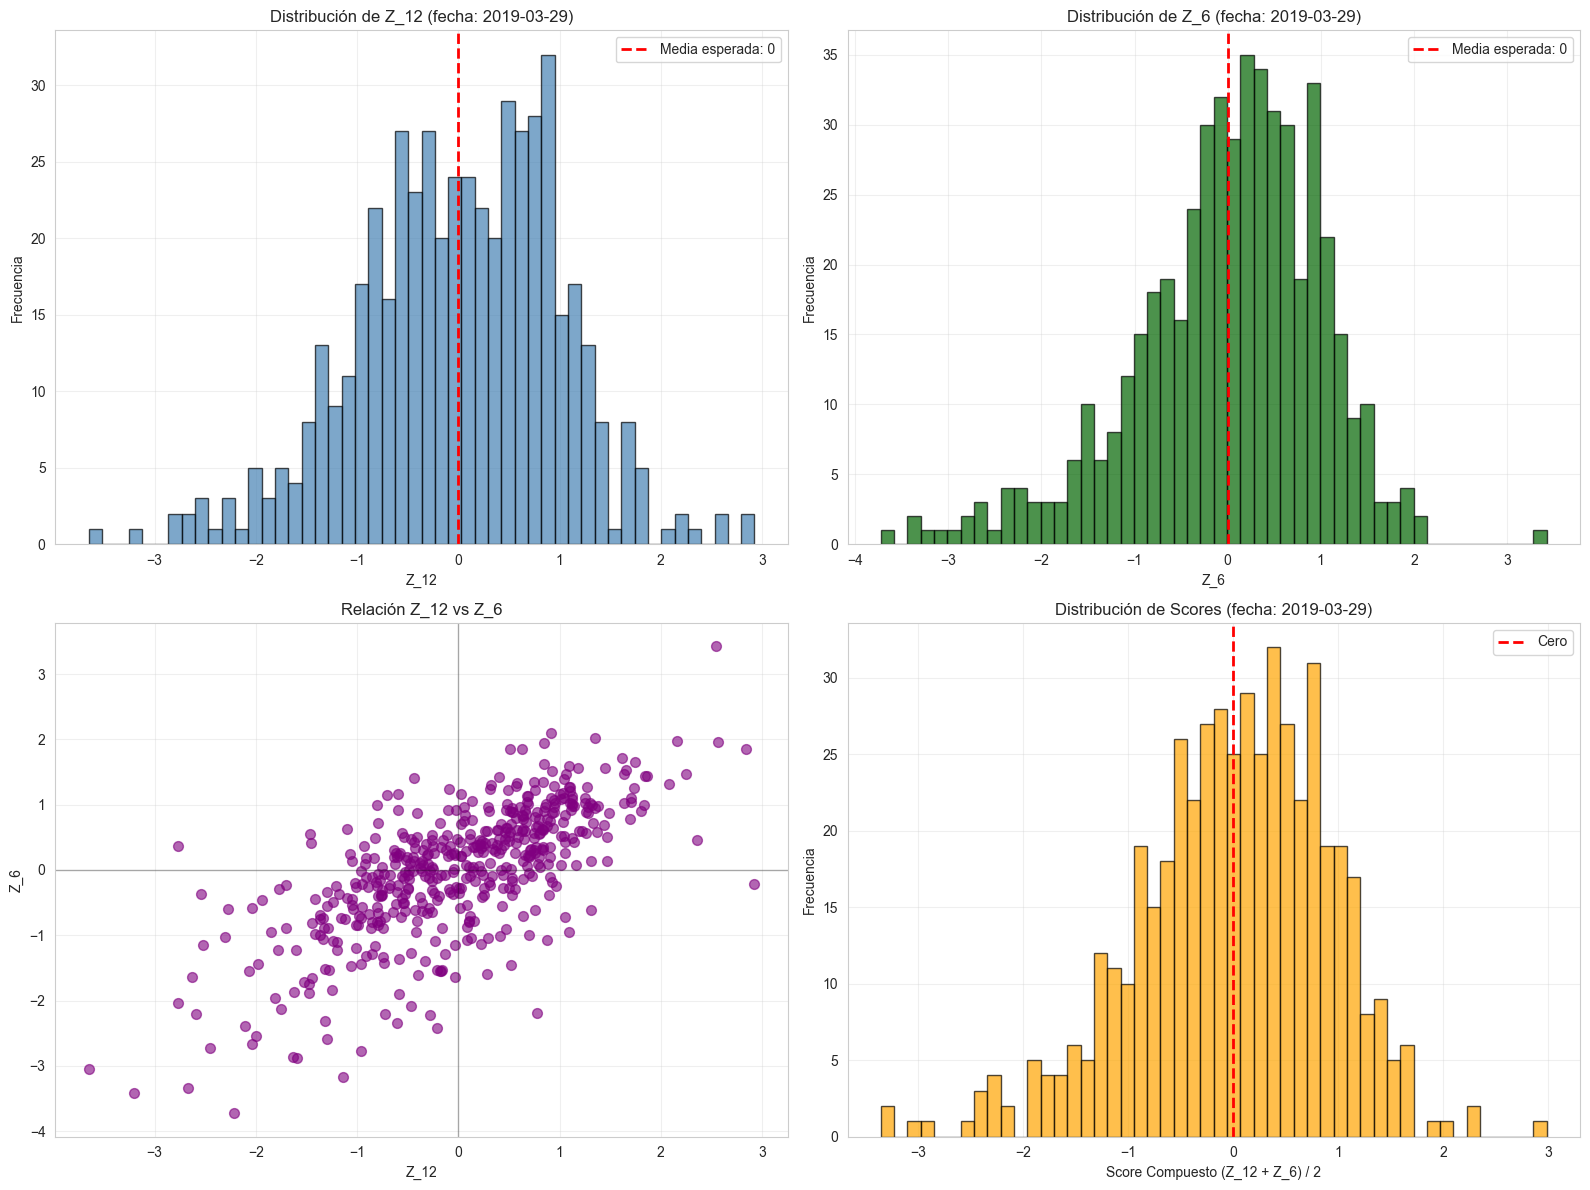

In [3]:
def calculate_z_scores(returns: pd.Series) -> pd.Series:
    """
    Calcula z-scores de retornos.
    
    Z-score = (r_i - mu) / sigma
    
    Parameters
    ----------
    returns : pd.Series
        Retornos de activos elegibles
    
    Returns
    -------
    pd.Series
        Z-scores normalizados
    """
    # Eliminar NaN antes de calcular
    returns_clean = returns.dropna()
    
    if len(returns_clean) < 2:
        # No hay suficientes activos para calcular z-scores
        return pd.Series(dtype=float)
    
    mu = returns_clean.mean()
    sigma = returns_clean.std()
    
    if sigma == 0:
        # Sin varianza, retornar 0s
        return pd.Series(0, index=returns_clean.index)
    
    z_scores = (returns_clean - mu) / sigma
    return z_scores


def calculate_momentum_score(R_12: pd.Series, R_6: pd.Series) -> pd.Series:
    """
    Calcula score compuesto de momentum.
    
    Score = (Z_12 + Z_6) / 2
    
    Parameters
    ----------
    R_12 : pd.Series
        Retornos acumulados 12 meses
    R_6 : pd.Series
        Retornos acumulados 6 meses
    
    Returns
    -------
    pd.Series
        Scores compuestos
    """
    # Calcular z-scores
    Z_12 = calculate_z_scores(R_12)
    Z_6 = calculate_z_scores(R_6)
    
    # Alinear índices (solo activos con ambos z-scores)
    common_idx = Z_12.index.intersection(Z_6.index)
    
    if len(common_idx) == 0:
        return pd.Series(dtype=float)
    
    # Score compuesto
    score = (Z_12.loc[common_idx] + Z_6.loc[common_idx]) / 2
    return score


def select_top_n(scores: pd.Series, n: int = 20) -> list:
    """
    Selecciona los n activos con mayor score.
    
    Parameters
    ----------
    scores : pd.Series
        Scores de momentum
    n : int
        Número de activos a seleccionar
    
    Returns
    -------
    list
        Tickers seleccionados (ordenados por score descendente)
    """
    # Eliminar NaN
    scores_clean = scores.dropna()
    
    # Ordenar descendente y tomar top n
    top_n = scores_clean.nlargest(n)
    
    return top_n.index.tolist()

    # Después del loop, antes de las visualizaciones actuales, agregar:

print("\n" + "="*70)
print("VALIDACIÓN DE Z-SCORES Y NORMALIZACIÓN")
print("="*70)


# Visualización 3: Distribución de Z-scores (validar normalización)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Para una fecha de ejemplo
fecha_viz = rebalance_dates[50]
elegibles_viz = eligibility_mask.loc[fecha_viz]
tickers_viz = elegibles_viz[elegibles_viz].index
R_12_viz = returns_12m_rebal.loc[fecha_viz, tickers_viz]
R_6_viz = returns_6m_rebal.loc[fecha_viz, tickers_viz]
Z_12_viz = calculate_z_scores(R_12_viz)
Z_6_viz = calculate_z_scores(R_6_viz)

# Histograma Z_12
axes[0, 0].hist(Z_12_viz.dropna(), bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 0].axvline(0, color='red', linestyle='--', linewidth=2, label='Media esperada: 0')
axes[0, 0].set_xlabel('Z_12')
axes[0, 0].set_ylabel('Frecuencia')
axes[0, 0].set_title(f'Distribución de Z_12 (fecha: {fecha_viz.date()})')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Histograma Z_6
axes[0, 1].hist(Z_6_viz.dropna(), bins=50, edgecolor='black', alpha=0.7, color='darkgreen')
axes[0, 1].axvline(0, color='red', linestyle='--', linewidth=2, label='Media esperada: 0')
axes[0, 1].set_xlabel('Z_6')
axes[0, 1].set_ylabel('Frecuencia')
axes[0, 1].set_title(f'Distribución de Z_6 (fecha: {fecha_viz.date()})')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Scatter Z_12 vs Z_6
scores_viz = calculate_momentum_score(R_12_viz, R_6_viz)
common_tickers = Z_12_viz.index.intersection(Z_6_viz.index)
axes[1, 0].scatter(Z_12_viz.loc[common_tickers], Z_6_viz.loc[common_tickers], 
                   alpha=0.6, s=50, color='purple')
axes[1, 0].set_xlabel('Z_12')
axes[1, 0].set_ylabel('Z_6')
axes[1, 0].set_title('Relación Z_12 vs Z_6')
axes[1, 0].axhline(0, color='black', linestyle='-', linewidth=1, alpha=0.3)
axes[1, 0].axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.3)
axes[1, 0].grid(alpha=0.3)

# Distribución de scores compuestos
axes[1, 1].hist(scores_viz.dropna(), bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1, 1].axvline(0, color='red', linestyle='--', linewidth=2, label='Cero')
axes[1, 1].set_xlabel('Score Compuesto (Z_12 + Z_6) / 2')
axes[1, 1].set_ylabel('Frecuencia')
axes[1, 1].set_title(f'Distribución de Scores (fecha: {fecha_viz.date()})')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Loop Principal de Selección {#loop}

Esta sección itera sobre todas las fechas de rebalanceo, aplicando el proceso completo de selección: filtrar elegibles, calcular scores y seleccionar top 20 activos por score de momentum.

**Decisiones clave:**
- **Loop mensual sobre fechas de rebalanceo**: La iteración mensual alinea con la frecuencia de rebalanceo de la estrategia y permite aplicar la metodología de selección de forma independiente en cada fecha, respetando el principio de que decisiones en fecha t solo usan información hasta t-1.
- **Filtrado por elegibilidad primero**: Antes de calcular scores, se filtran solo activos elegibles usando `eligibility_mask`. Esto controla sesgos (look-ahead, supervivencia) y garantiza que solo se consideren activos con suficiente histórico y en el S&P 500, tal como se definió en el Notebook 2.
- **Top 30 por score descendente**: Se seleccionan los 30 activos con mayor score compuesto, ordenados de mayor a menor. Los primeros 20 se guardan como selección principal (`ticker_1` a `ticker_20`) y los siguientes 10 como reservas (`reserva_1` a `reserva_10`). Este sistema de reservas permite al Notebook 4 reemplazar automáticamente activos que sufran delistings entre la fecha de selección y la fecha de ejecución, garantizando que la cartera siempre tenga exactamente 20 activos válidos. El ordenamiento por score garantiza que ticker_1 tiene el mayor momentum en cada fecha, y las reservas son los siguientes mejores candidatos disponibles.

In [4]:
print("\n" + "="*70)
print("EJECUTANDO SELECCIÓN MENSUAL")
print("="*70)

# Inicializar resultados
selecciones = []
estadisticas = []

# Loop sobre fechas de rebalanceo
for i, fecha in enumerate(rebalance_dates):
    
    # 1. Obtener activos elegibles este mes
    elegibles = eligibility_mask.loc[fecha]
    tickers_elegibles = elegibles[elegibles].index
    n_elegibles = len(tickers_elegibles)
    
    # 2. Obtener retornos pre-calculados (solo elegibles)
    R_12 = returns_12m_rebal.loc[fecha, tickers_elegibles]
    R_6 = returns_6m_rebal.loc[fecha, tickers_elegibles]
    
    # 3. Calcular scores
    scores = calculate_momentum_score(R_12, R_6)
    
    # 4. Seleccionar top 30 (20 principales + 10 reservas para manejar delistings)
    # Las reservas permiten reemplazo automático en Notebook 4 si algún ticker del top 20
    # no tiene precio disponible en la fecha de ejecución debido a delistings
    top_30 = select_top_n(scores, n=30)
    
    # 5. Validación
    if len(top_30) < 30:
        print(f"ADVERTENCIA: Fecha {fecha}, solo {len(top_30)} activos disponibles (se requieren 30)")
    
    # 6. Guardar selección: primeros 20 como selección principal, siguientes 10 como reservas
    seleccion_dict = {'fecha': fecha}
    
    # Guardar top 20 principales
    for j in range(min(20, len(top_30))):
        seleccion_dict[f'ticker_{j+1}'] = top_30[j]
    
    # Guardar siguientes 10 como reservas (posiciones 21-30)
    for j in range(10):
        if 20 + j < len(top_30):
            seleccion_dict[f'reserva_{j+1}'] = top_30[20 + j]
        else:
            seleccion_dict[f'reserva_{j+1}'] = None
    
    selecciones.append(seleccion_dict)
    
    # 7. Guardar estadísticas
    estadisticas.append({
        'fecha': fecha,
        'n_elegibles': n_elegibles,
        'n_seleccionados': len(top_30),
        'score_min': scores.min() if len(scores) > 0 else np.nan,
        'score_max': scores.max() if len(scores) > 0 else np.nan,
        'score_mean': scores.mean() if len(scores) > 0 else np.nan
    })
    
    # Progress cada 20 fechas
    if (i + 1) % 20 == 0:
        print(f"  Procesadas {i+1}/{len(rebalance_dates)} fechas")

print(f"\n✓ Selección completada: {len(selecciones)} fechas procesadas")

# Convertir a DataFrames
df_selecciones = pd.DataFrame(selecciones)
df_estadisticas = pd.DataFrame(estadisticas)


EJECUTANDO SELECCIÓN MENSUAL
  Procesadas 20/133 fechas
  Procesadas 40/133 fechas
  Procesadas 60/133 fechas
  Procesadas 80/133 fechas
  Procesadas 100/133 fechas
  Procesadas 120/133 fechas

✓ Selección completada: 133 fechas procesadas


## 5. Visualizaciones y Validaciones {#visualizaciones}

Esta sección analiza la evolución temporal del proceso de selección y valida la integridad de los resultados generados, asegurando calidad antes de pasar al backtesting.

**Decisiones clave:**
- **Validación de integridad (sin duplicados, 20 principales + 10 reservas)**: Se verifica que cada fecha tenga exactamente 20 activos principales (`ticker_1` a `ticker_20`) y 10 reservas (`reserva_1` a `reserva_10`), todos únicos y sin duplicados. Esta validación es crítica para detectar errores de implementación que podrían generar carteras inválidas (duplicados, menos de 20 principales) que afectarían los resultados del backtesting en el Notebook 4. El sistema de reservas garantiza que siempre haya candidatos disponibles para reemplazar activos con delistings.
- **Análisis de recurrencia de tickers**: Se analiza qué tickers aparecen más frecuentemente en las selecciones para evaluar estabilidad de la estrategia. Alta recurrencia indica que ciertos activos mantienen momentum consistente; baja recurrencia sugiere rotación alta, lo cual es esperado en estrategias momentum pero debe monitorearse para costos de transacción.
- **Visualización de evolución temporal**: Los gráficos muestran evolución del universo elegible y distribución de scores a lo largo del tiempo, permitiendo identificar períodos con universos pequeños o scores extremos que podrían indicar cambios de régimen de mercado o problemas de datos.


VISUALIZACIONES Y VALIDACIONES


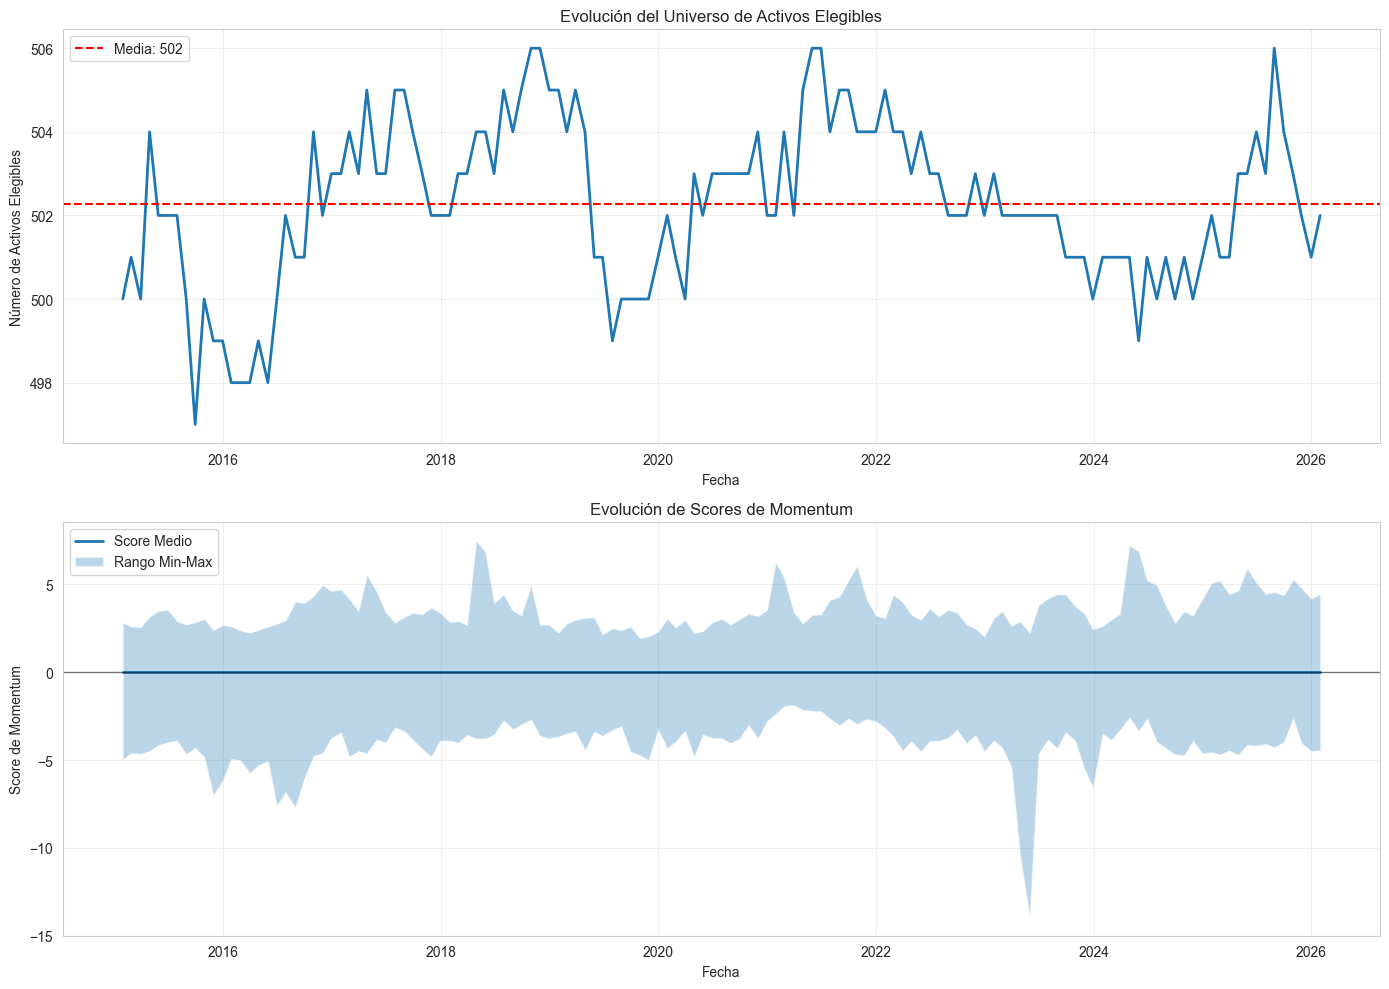


Análisis de recurrencia de tickers:
  Tickers únicos seleccionados: 413
  Top 10 más frecuentes:
NVDA    76
NFLX    43
AMD     42
MU      33
AVGO    32
AMAT    30
NRG     29
AMZN    28
LRCX    27
RCL     25
Name: count, dtype: int64

Validaciones:
  Todas las filas tienen 20 tickers principales: True
  Todas las filas tienen 10 reservas: True
  Sin duplicados en tickers principales: True
  Sin duplicados en reservas: True
  Sin overlap entre principales y reservas: True


In [5]:
print("\n" + "="*70)
print("VISUALIZACIONES Y VALIDACIONES")
print("="*70)

# Gráfico 1: Evolución de activos elegibles
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

axes[0].plot(df_estadisticas['fecha'], df_estadisticas['n_elegibles'], linewidth=2)
axes[0].set_xlabel('Fecha')
axes[0].set_ylabel('Número de Activos Elegibles')
axes[0].set_title('Evolución del Universo de Activos Elegibles')
axes[0].grid(alpha=0.3)
axes[0].axhline(df_estadisticas['n_elegibles'].mean(), color='red', 
                linestyle='--', label=f"Media: {df_estadisticas['n_elegibles'].mean():.0f}")
axes[0].legend()

# Gráfico 2: Distribución de scores
axes[1].plot(df_estadisticas['fecha'], df_estadisticas['score_mean'], 
             label='Score Medio', linewidth=2)
axes[1].fill_between(df_estadisticas['fecha'], 
                      df_estadisticas['score_min'], 
                      df_estadisticas['score_max'], 
                      alpha=0.3, label='Rango Min-Max')
axes[1].set_xlabel('Fecha')
axes[1].set_ylabel('Score de Momentum')
axes[1].set_title('Evolución de Scores de Momentum')
axes[1].grid(alpha=0.3)
axes[1].legend()
axes[1].axhline(0, color='black', linewidth=1, linestyle='-', alpha=0.5)

plt.tight_layout()
plt.show()

# Análisis de recurrencia de tickers
print("\nAnálisis de recurrencia de tickers:")
all_selected_tickers = []
for col in df_selecciones.columns:
    if col.startswith('ticker_'):
        all_selected_tickers.extend(df_selecciones[col].dropna().tolist())

ticker_counts = pd.Series(all_selected_tickers).value_counts()
print(f"  Tickers únicos seleccionados: {len(ticker_counts)}")
print(f"  Top 10 más frecuentes:")
print(ticker_counts.head(10))

# Validaciones
print("\nValidaciones:")
# Verificar que todas las filas tienen 20 tickers principales
tickers_cols = [col for col in df_selecciones.columns if col.startswith('ticker_')]
tickers_por_fila = df_selecciones[tickers_cols].notna().sum(axis=1)
todos_tienen_20_principales = (tickers_por_fila == N_ACTIVOS_SELECCION).all()

# Verificar que todas las filas tienen 10 reservas
reservas_cols = [col for col in df_selecciones.columns if col.startswith('reserva_')]
reservas_por_fila = df_selecciones[reservas_cols].notna().sum(axis=1)
todos_tienen_10_reservas = (reservas_por_fila == 10).all()

# Verificar sin duplicados en tickers principales
sin_duplicados_principales = df_selecciones[tickers_cols].apply(
    lambda x: x.nunique() == x.notna().sum(), axis=1
).all()

# Verificar sin duplicados en reservas
sin_duplicados_reservas = df_selecciones[reservas_cols].apply(
    lambda x: x.nunique() == x.notna().sum(), axis=1
).all()

# Verificar que no hay overlap entre principales y reservas
sin_overlap = True
for idx, row in df_selecciones.iterrows():
    tickers_princ = set(row[tickers_cols].dropna().values)
    reservas_vals = set(row[reservas_cols].dropna().values)
    if tickers_princ.intersection(reservas_vals):
        sin_overlap = False
        break

print(f"  Todas las filas tienen 20 tickers principales: {todos_tienen_20_principales}")
print(f"  Todas las filas tienen 10 reservas: {todos_tienen_10_reservas}")
print(f"  Sin duplicados en tickers principales: {sin_duplicados_principales}")
print(f"  Sin duplicados en reservas: {sin_duplicados_reservas}")
print(f"  Sin overlap entre principales y reservas: {sin_overlap}")

## 6. Guardado de Resultados {#guardado}

Esta sección guarda las selecciones mensuales en formato CSV, preparando el output para el motor de backtesting del Notebook 4.

**Decisiones clave:**
- **Formato CSV para compatibilidad**: Se usa CSV en lugar de Parquet para las selecciones porque es formato estándar, legible por humanos y compatible con la mayoría de motores de backtesting. El archivo es pequeño (133 filas × 21 columnas) por lo que la eficiencia de Parquet no es crítica aquí.
- **Estructura fecha + tickers + reservas**: El formato incluye columna `fecha`, seguida de `ticker_1` a `ticker_20` (top 20 principales, ordenados por score descendente) y `reserva_1` a `reserva_10` (siguientes 10 mejores candidatos). Esta estructura permite al Notebook 4 reemplazar automáticamente activos que sufran delistings usando las reservas, garantizando que la cartera siempre tenga exactamente 20 activos válidos. El formato es estándar para motores de backtesting y facilita la carga y procesamiento sin transformaciones adicionales.
- **Guardado en directorio processed**: El archivo se guarda en `datos/processed/` junto con otros outputs del pipeline, manteniendo organización consistente y facilitando que el Notebook 4 encuentre automáticamente el archivo de selecciones para ejecutar el backtesting.

In [6]:
print("\n" + "="*70)
print("GUARDANDO SELECCIONES")
print("="*70)

# Guardar CSV
output_path = f'{DATA_PROCESSED_DIR}/selecciones_mensuales.csv'
df_selecciones.to_csv(output_path, index=False)

print(f"✓ Archivo guardado: {output_path}")
print(f"  Dimensiones: {df_selecciones.shape}")
print(f"  Columnas: fecha + {N_ACTIVOS_SELECCION} tickers principales + 10 reservas")

# Mostrar primeras y últimas selecciones
print("\nPrimeras 3 selecciones:")
print(df_selecciones.head(3))

print("\nÚltimas 3 selecciones:")
print(df_selecciones.tail(3))

print("\n" + "="*70)
print("NOTEBOOK 3 COMPLETADO")
print("="*70)
print("\nPróximo paso: Notebook 4 - Motor de Backtesting")


GUARDANDO SELECCIONES
✓ Archivo guardado: ../datos/processed/selecciones_mensuales.csv
  Dimensiones: (133, 31)
  Columnas: fecha + 20 tickers principales + 10 reservas

Primeras 3 selecciones:
       fecha    ticker_1 ticker_2 ticker_3 ticker_4      ticker_5    ticker_6  \
0 2015-01-30         LUV       EW     AVGO       EA           RCL        MNST   
1 2015-02-27         LUV       EA     MNST     AVGO  MNKKQ-202206          KR   
2 2015-03-31  HSP-201509     AVGO     MNST       EA   ANDV-201809  AGN-201503   

     ticker_7      ticker_8 ticker_9  ...   reserva_1 reserva_2    reserva_3  \
0  AGN-201503  MNKKQ-202206      DAL  ...         MAC       KDP          SHW   
1          EW    AGN-201503     BBWI  ...  GGP-201808       SHW          UNH   
2         LUV          BBWI       EW  ...         COR       UNH  SIAL-201511   

     reserva_4 reserva_5 reserva_6    reserva_7    reserva_8 reserva_9  \
0  GMCR-201603      ROST      WELL  AABA-201910          KMX       LEG   
1   CFN-201